## 1. Imports & Setup

In [25]:
# Core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm

# Text preprocessing helpers
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Sentiment analysis
from textblob import TextBlob

# Paths
os.makedirs("../results/eda", exist_ok=True)
os.makedirs("../data/raw", exist_ok=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajsal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Load & Merge Data

In [26]:
# Using Kaggle dataset (True.csv & Fake.csv in data/raw/)
real_df = pd.read_csv("../data/raw/True.csv")
fake_df = pd.read_csv("../data/raw/Fake.csv")

real_df["label"] = 0  # Real
fake_df["label"] = 1  # Fake

df = pd.concat([real_df, fake_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle
print(df.shape)
df.head()

(44898, 5)


,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",1
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",1
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",1
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",0
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",1


## 3. Basic Overview

In [27]:
df.info()
df.isnull().sum()
print(df["label"].value_counts())

# Convert 'label' to readable form for visualization
df["label_name"] = df["label"].map({0: "Real", 1: "Fake"})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
label
1    23481
0    21417
Name: count, dtype: int64


## 4. Class Distribution

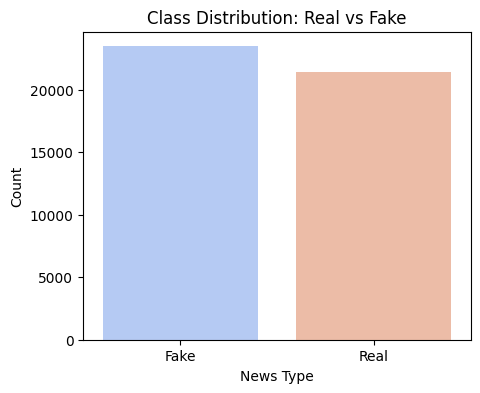

In [28]:
plt.figure(figsize=(5,4))
sns.countplot(x="label_name", hue="label_name", data=df, palette="coolwarm", legend=False)
plt.title("Class Distribution: Real vs Fake")
plt.xlabel("News Type")
plt.ylabel("Count")
plt.savefig("../results/eda/class_distribution.png", bbox_inches="tight")
plt.show();

## 5. Text Length Analysis

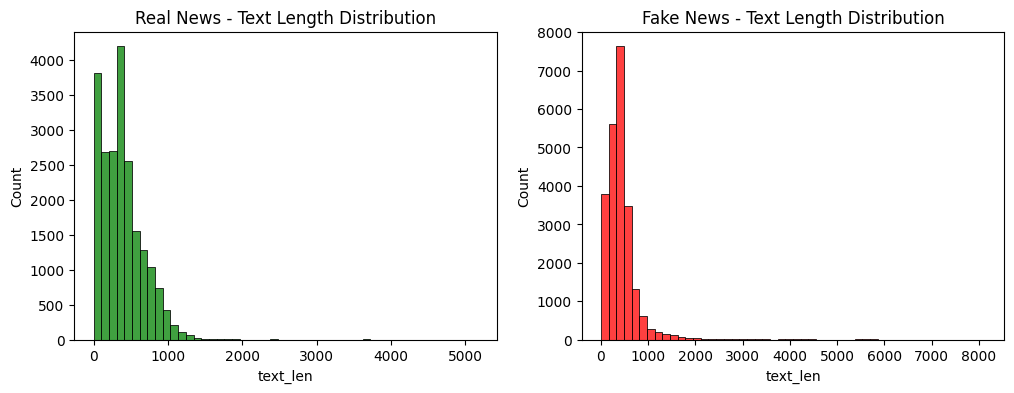

In [29]:
df["text_len"] = df["text"].apply(lambda x: len(str(x).split()))
df["title_len"] = df["title"].apply(lambda x: len(str(x).split()))

fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df[df.label==0]["text_len"], bins=50, ax=ax[0], color='green')
ax[0].set_title("Real News - Text Length Distribution")

sns.histplot(df[df.label==1]["text_len"], bins=50, ax=ax[1], color='red')
ax[1].set_title("Fake News - Text Length Distribution")

plt.savefig("../results/eda/text_length_dist.png", bbox_inches="tight")
plt.show();

## 6. Subject-wise Distribution

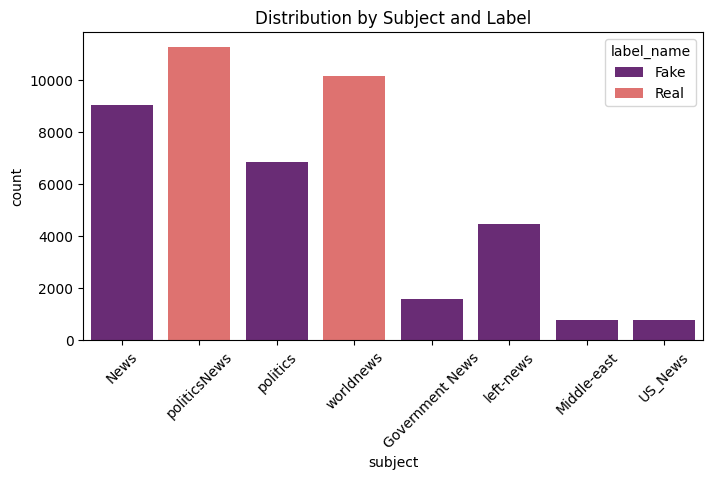

In [30]:
if "subject" in df.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x="subject", hue="label_name", palette="magma")
    plt.title("Distribution by Subject and Label")
    plt.xticks(rotation=45)
    plt.savefig("../results/eda/subject_dist.png", bbox_inches="tight")
    plt.show();

## 7. Word Frequency & WordClouds

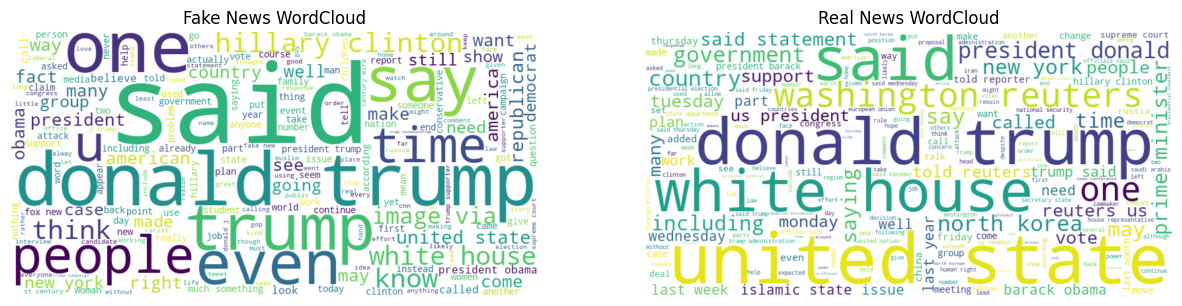

In [31]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    return " ".join([w.lower() for w in text.split() if w.lower() not in stop_words])

df["clean_text"] = df["text"].apply(clean_text)

# Separate corpora
fake_text = " ".join(df[df.label==1]["clean_text"].tolist())
real_text = " ".join(df[df.label==0]["clean_text"].tolist())

# Generate WordClouds
wc_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
wc_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)

fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].imshow(wc_fake, interpolation='bilinear')
ax[0].set_title("Fake News WordCloud")
ax[0].axis("off")

ax[1].imshow(wc_real, interpolation='bilinear')
ax[1].set_title("Real News WordCloud")
ax[1].axis("off")

plt.savefig("../results/eda/wordclouds.png", bbox_inches="tight")
plt.show();

## 8. Sentiment Distribution

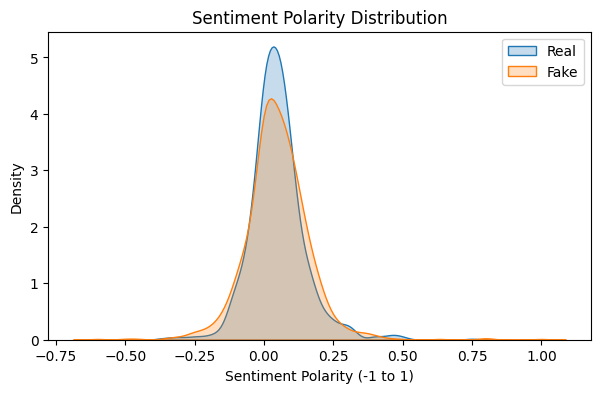

In [32]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df_sample = df.sample(2000, random_state=42)  # small subset for speed
df_sample["sentiment"] = df_sample["clean_text"].apply(get_sentiment)

plt.figure(figsize=(7,4))
sns.kdeplot(df_sample[df_sample.label==0]["sentiment"], label="Real", fill=True)
sns.kdeplot(df_sample[df_sample.label==1]["sentiment"], label="Fake", fill=True)
plt.title("Sentiment Polarity Distribution")
plt.xlabel("Sentiment Polarity (-1 to 1)")
plt.legend()
plt.savefig("../results/eda/sentiment_dist.png", bbox_inches="tight")
plt.show();

## 9. Quantitative Summary

In [33]:
summary = df.groupby("label_name").agg({
    "text_len": ["mean", "std"],
    "title_len": ["mean", "std"]
}).round(1)
summary

text_len        title_len     
               mean    std      mean  std
label_name                               
Fake          423.2  408.4      14.7  4.3
Real          385.6  274.0      10.0  1.7

## 10. Key Insights

**Dataset:** 44,898 articles across `title`, `text`, `subject`, `date`, `label`; clean with no major missing values.

**Class Balance:** Slight skew — ~52% Fake vs ~48% Real.

**Text Length:** Fake articles are longer and more variable (avg ≈ 423 words) than real ones (≈ 386 words).

**Titles:** Fake titles are longer and more sensational (≈15 words) vs real (≈10 words).

**Subjects:** Some topics are label-biased (e.g., politics has more fake entries).

**Overall Insight:** Fake news tends to use longer, flashier language; data is clean and ready for modeling with minor imbalance handling.

## 11. Save Cleaned EDA Data for Next Stage

In [34]:
os.makedirs("../data/processed", exist_ok=True)
df.to_csv("../data/processed/cleaned_for_preprocessing.csv", index=False)